# Reconstructing trees with Cassiopeia

Cassiopeia offers several utilities for reconstructing phylogenies, carrying users from the allele tables they've created in the [benchmarking tutorial]() to the full phylogeneis. This tutorial serves as a general overview of the tools that Cassiopeia offers for tree reconstruction.

In [1]:
from IPython.display import Image

import numpy as np
import pandas as pd

import cassiopeia as cas

## Creating character matrices
The first step in any tree reconstruction task is the creation of character matrices. In Cassiopeia, character matrices are the fundamental data structure representing mutation information in a clonal lineage (e.g., a single embryo or a tumor).

While users can create their own, Cassiopeia offers utilities for converting allele tables into character matrices. Below, we demonstrate how this is done on an example dataset from [Quinn et al](https://science.sciencemag.org/content/371/6532/eabc1944).

### Reading in and inspecting the data

In [2]:
# read in an allele table
allele_table = pd.read_csv("https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4905nnn/GSM4905334/suppl/GSM4905334_alleleTable.5k.txt.gz", sep='\t',
                           usecols = ['cellBC', 'intBC', 'r1', 'r2', 'r3', 'allele', 'LineageGroup', 'sampleID', 'readCount', 'UMI'])

As you see below, this `allele table` reports on the allelic information for each intBC in each cellBC. In addition, we have annotated each cellBC by which clone it came from (denoted by the `LineageGroup` column) and which tissue it came from (denoted by the `sampleID` column). Before reconstructing trees, we'll want to select a specific clone for reconstruction -- recall that we want to only reconstruct trees for clonally-related cells!

<div class="alert alert-block alert-warning" style="color:black;">
<b>Warning:</b> The semantics used above correspond specifically to the molecular recorder technology described in <a href="https://www.nature.com/articles/s41586-019-1184-5">Chan et al, 2019</a>. Depending on your technology, you might not have the equivalent of intBCs or lineage-groups. For example, the GESTALT technology as described in <a href url="https://www.nature.com/articles/nbt.4103">Raj et al, 2018</a> does not have intBCs. Moreover, be sure you know what a "clonal" population indicates in your dataset - for example, each embryo might be considered a clonal population. 
</div>



In [3]:
allele_table.head(5)

,cellBC,intBC,r1,r2,r3,allele,LineageGroup,sampleID,readCount,UMI
0,RW.TTTGTCATCAGCTCGG-1,CTCCCCCAATACCG,GACAA[115:23I]CTTAACTTTGTATGGTCCTTTGTATGGC,TAACG[163:27D]ATGTC,TAATT[219:2D]CGGAG,GACAA[115:23I]CTTAACTTTGTATGGTCCTTTGTATGGCTAAC...,24,RW,529,9
1,RW.TTTGTCATCAGCTCGG-1,ACACATAACTTTAG,CGCCG[111:1I]AAAAAA,ACGAT[165:25D]ATGTC,TAATT[219:2D]CGGAG,CGCCG[111:1I]AAAAAAACGAT[165:25D]ATGTCTAATT[21...,24,RW,719,14
2,RW.TTTGTCATCAGCTCGG-1,AGATAACGGCAAGT,CCTTT[103:34D]GCACG,GTCAT[159:9D]GTTGG,AATTC[220:1I]TGCGGA,CCTTT[103:34D]GCACGGTCAT[159:9D]GTTGGAATTC[220...,24,RW,459,9
3,RW.TTTGTCATCAGCTCGG-1,CACACTCACGATGA,CGCCG[111:1I]AAAAAA,CGATA[166:4D]TGGTT,TAATT[219:2D]CGGAG,CGCCG[111:1I]AAAAAACGATA[166:4D]TGGTTTAATT[219...,24,RW,760,10
4,RW.TTTGTCATCAGCTCGG-1,CATACGCCATGAGG,CGCCG[111:1I]AAAAAA,GATAT[None]CTCTG,TAGCA[206:42D]GTCTT,CGCCG[111:1I]AAAAAAGATAT[None]CTCTGTAGCA[206:4...,24,RW,351,6


### Estimating indel priors
Because we've sampled ~100 clonal populations, we can leverage the fact that each of these clones represents an independent lineage-tracing experiment to estimate the probability of a particular indel occurring. This will be helpful for reconstruction tasks downstream.

To do this, we use `cas.pp.compute_empirical_indel_priors`. Here we treat each `intBC` in each clonal population as an independent group so we'll estimate priors by counting the proportion of times that an indel appeared on a `intBC`

In [4]:
indel_priors = cas.pp.compute_empirical_indel_priors(allele_table, grouping_variables=['intBC', 'LineageGroup'])

After doing this, we can observe the most frequent indels, appearing on most `intBCs` across our dataset.

In [5]:
indel_priors.sort_values(by='count', ascending=False).head()

,count,freq
indel,,
CGCCG[111:1I]AAAAAA,832.0,0.797699
TAATT[219:2D]CGGAG,713.0,0.683605
CGATA[166:1I]TTCTCT,611.0,0.585810
AATTC[220:1I]GGCGGA,610.0,0.584851
ATTCG[221:1D]GGAGG,524.0,0.502397


With indel priors calculated, we'll subset our allele table to a clone of interest and create a character matrix. This can be done by passing the clone's allele table to `cas.pp.convert_alleletable_to_character_matrix` which will transform the allele table into an `N x M` character matrix. We'll also pass in the indel priors we just computed, which will be transformed into a dictionary relating each unique state observed in each character to a probability. This new `priors` object will be specific to the character matrix we're computing.

The function for converting allele tables to character matrices has additional capabilities for filtering out low-information characters. Not only can users specify a subset of intBCs to ignore, but we can also filter out characters by dominated by a single state (this proportion can be controlled by `allele_rep_thresh`). Here we filter out characters that have an indel spanning more than 90% of cells.

In [6]:
CLONE = 45
clone_allele_table = allele_table[allele_table['LineageGroup'] == CLONE]

n_cells = clone_allele_table['cellBC'].nunique()
n_intbc = clone_allele_table['intBC'].nunique()

print(f"Clonal population #{CLONE} has {n_cells} cells and {n_intbc} intBCs ({n_intbc * 3}) characters.")

Clonal population #45 has 98 cells and 26 intBCs (78) characters.


In [7]:
character_matrix, priors, state_2_indel = cas.pp.convert_alleletable_to_character_matrix(clone_allele_table,
                                                                                         allele_rep_thresh = 0.9,
                                                                                         mutation_priors = indel_priors) 

Dropping the following intBCs due to lack of diversity with threshold 0.9: ['CCGTTCCAATTGTGr3', 'GACTCATGACACTTr1', 'TCAATGAGAGTTCTr1', 'TCAATGAGAGTTCTr2', 'TCAATGAGAGTTCTr3', 'TTCTTTTTACCGCGr1', 'TTCTTTTTACCGCGr2', 'CCCGAGCTAATCCTr3']


Processing characters:   0%|          | 0/70 [00:00<?, ?it/s]

### The data struture
This simple data structure is an `N x M` matrix, where we represent each of the `N` cells in a population by a vector of `M` characters that can take on a mutation. In the context of Cas9-based lineage tracers, each of these `M` characters is a specific cut-site that can take on one of several possible indels. The entry $n_{i, j}$ represents that mutation observed in the $i^{th}$ cell at the $j^{th}$ cut-site. For simplicity, we abstract away actual indentities and represent each unique mutation as integer, so that these character matrices are filled with integers. Importantly, Cassiopeia represents missing data with the integer `-1`, though users can change this as long as they specify this to the CassiopeiaTree downstream.

In [8]:
character_matrix.head(5)

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,...,r61,r62,r63,r64,r65,r66,r67,r68,r69,r70
RW.TTTGCGCCAAGAAAGG-1,0,0,1,0,0,1,0,0,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
RW.GTTCTCGAGGGTTTCT-1,0,0,0,0,0,0,1,0,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
RW.GTCATTTTCCATTCTA-1,1,1,2,0,0,2,0,0,1,1,...,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
RW.GGGATGATCGCGCCAA-1,2,2,3,0,0,0,2,1,2,0,...,0,0,0,0,1,0,0,0,0,0
RW.GGCTGGTAGTCAATAG-1,0,0,1,0,0,1,0,0,1,1,...,0,-1,-1,-1,-1,-1,-1,-1,-1,-1


We can also observe the new prior dictionary we created. Indexing the dictionary by `0` gives the priors for the states observed in the 1st character.

<div class="alert alert-block alert-warning" style="color:black;">
<b>Heads up:</b> States are not consistent across characters, so priors need not align between characters. Do not be alarmed if state 1 has a different prior between characters!
</div>


In [9]:
priors[0]

{1: 0.003835091083413231,
 2: 0.0009587727708533077,
 3: 0.0028763183125599234,
 4: 0.0009587727708533077,
 5: 0.26558005752636626,
 6: 0.23585810162991372,
 7: 0.01725790987535954,
 8: 0.7976989453499521,
 9: 0.0028763183125599234}

## Reconstructing trees

With the character matrix and priors we just created, we are ready to reconstruct trees! Cassiopeia offers a general interface for working with trees, including reconstruction.


### Working with CassiopeiaTrees
At its core is the `CassiopeiaTree` class -- this is a general data structure that can store tree topologies, character matrices (with various layers), priors, branch lengths, and other meta data. Importantly, all of our solvers derive from a central `CassiopeiaSolver` class that at a minimum implements a single function - `solve` - that ingests a `CassiopeiaTree` and populates the tree topology within the object. To see how this works, let's work with the character matrix we just created above.

In [10]:
cas_tree = cas.data.CassiopeiaTree(character_matrix=character_matrix, priors=priors)

The `CassiopeiaTree` constructor will populate the object automatically with the specified information which we can explore here.

In [11]:
cas_tree.character_matrix.head(5)

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r10,...,r61,r62,r63,r64,r65,r66,r67,r68,r69,r70
RW.TTTGCGCCAAGAAAGG-1,0,0,1,0,0,1,0,0,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
RW.GTTCTCGAGGGTTTCT-1,0,0,0,0,0,0,1,0,1,1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
RW.GTCATTTTCCATTCTA-1,1,1,2,0,0,2,0,0,1,1,...,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
RW.GGGATGATCGCGCCAA-1,2,2,3,0,0,0,2,1,2,0,...,0,0,0,0,1,0,0,0,0,0
RW.GGCTGGTAGTCAATAG-1,0,0,1,0,0,1,0,0,1,1,...,0,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [12]:
cas_tree.n_cell, cas_tree.n_character, 

(98, 70)

In [13]:
cas_tree.priors[0]

{1: 0.003835091083413231,
 2: 0.0009587727708533077,
 3: 0.0028763183125599234,
 4: 0.0009587727708533077,
 5: 0.26558005752636626,
 6: 0.23585810162991372,
 7: 0.01725790987535954,
 8: 0.7976989453499521,
 9: 0.0028763183125599234}

We can also add important cellular-level and character-level meta data to the `CassiopeiaTree` object:

In [14]:
cell_meta = clone_allele_table.groupby('cellBC').agg({"intBC": 'nunique', 'UMI': 'sum', 'sampleID': 'unique'})
cell_meta['sampleID'] = [x[0] for x in cell_meta['sampleID']]

missing_proportion = (character_matrix == -1).sum(axis=0) / character_matrix.shape[0]
uncut_proportion = (character_matrix == 0).sum(axis=0) / character_matrix.shape[0]
n_unique_states = character_matrix.apply(lambda x: len(np.unique(x[(x != 0) & (x != -1)])), axis=0)

character_meta = pd.DataFrame([missing_proportion, uncut_proportion, n_unique_states], index = ['missing_prop', 'uncut_prop', 'n_unique_states']).T

cas_tree.cell_meta = cell_meta
cas_tree.character_meta = character_meta

In [15]:
cas_tree.cell_meta.head(5)

,intBC,UMI,sampleID
cellBC,,,
Liv.CAGTAACGTTGCTCCT-1,22,557,Liv
Liv.CGATTGAAGGTGCTAG-1,20,475,Liv
M1.AAACCTGCACGCCAGT-1,14,33,M1
M1.AAAGATGCAGCGTAAG-1,12,37,M1
M1.AAAGTAGAGCCAGTTT-1,23,96,M1


In [16]:
cas_tree.character_meta.head(5)

,missing_prop,uncut_prop,n_unique_states
r1,0.479592,0.357143,9.0
r2,0.479592,0.295918,14.0
r3,0.479592,0.377551,8.0
r4,0.255102,0.112245,5.0
r5,0.255102,0.510204,14.0


### Creating and working with CassiopeiaSolvers

As mentioned previously, Cassiopeia works with a general class of CassiopeiaSolvers. We have implemented several solvers, which you can find [here](https://cassiopeia-lineage.readthedocs.io/en/testdeployment/api/solver.html).

Perhaps the most popular are the `VanillaGreedySolver`, `ILPSolver`, `HybridSolver`, and `NeighborJoiningSolver`. Here, we'll provide a quick overview of each of these.

<div class="alert alert-block alert-info" style="color:black;">
<b>Tip:</b> We recommend using a panel of solvers for your reconstruction tasks. It is rare for a particular solver to be optimal over all parts of the tree, so using a few different solvers can give you an idea of relative certainty over any downstream tasks. 
</div>

<div class="alert alert-block alert-warning" style="color:black;">
<b>Heads up:</b> If priors are specified in the CassiopeiaTree object, they will automatically be used in the solver.
</div>

We'll use the `VanillaGreedySolver` to showcase the basics of the solver API.

In [17]:
# create a basic vanilla greedy solver
vanilla_greedy = cas.solver.VanillaGreedySolver()

# reconstruct the tree
vanilla_greedy.solve(cas_tree, collapse_mutationless_edges=True)

In [79]:
# plot tree
cas.pl.upload_and_export_itol(cas_tree, itol_config="~/.itolconfig_hidden",
                              tree_name = "example_greedy_tree", export_filepath="example_greedy_tree.png")

iTOL output: SUCCESS: 12832112124272501627507287

Tree Web Page URL: http://itol.embl.de/external.cgi?tree=12832112124272501627507287&restore_saved=1
Warnings: []


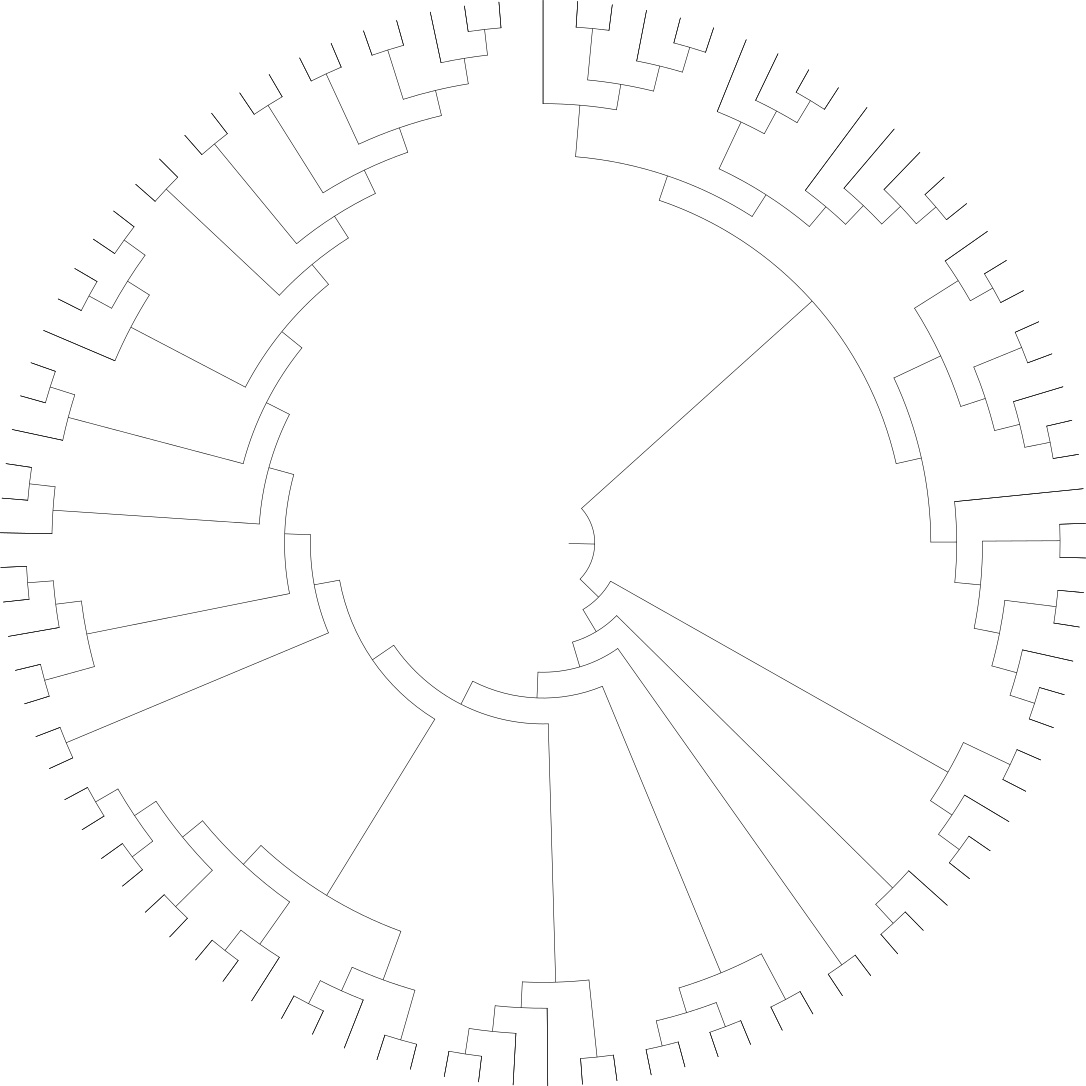

In [81]:
Image("example_greedy_tree.png", width=500, height=500)

### Neighbor-Joining

The `NeighborJoiningSolver` extends the `DistanceSolver` class which additionally takes into the constructor a dissimilarity map (or, a function that be used to relate two samples to one another). We've implemented several dissimilary maps in the `cas.solver.dissimilarity` library but suggest any technology using a Cas9 recorder use the `modified_hamming_distance` function.

To note, since Neighbor-Joining returns an unrooted tree, we attempt to re-root the tree. This can be done by adding a sample corresponding to the uncut-state (this is accomplished by setting `add_root=True`) or by specifying a sample in the character matrix to treat as an outgroup.

<div class="alert alert-block alert-info" style="color:black;">
<b>Tip:</b> A user can impelement their own dissimilarity map, as long as it takes in two character state vectors and weights, and returns a positive value representing a dissimilarity. Ideally, the function is optimizable with <i>Numba</i> but this is not needed.
</div>

In [20]:
nj_solver = cas.solver.NeighborJoiningSolver(dissimilarity_function=cas.solver.dissimilarity.weighted_hamming_distance, add_root=True)
nj_solver.solve(cas_tree, collapse_mutationless_edges=True)

In [21]:
# plot tree
cas.pl.upload_and_export_itol(cas_tree, itol_config="~/.itolconfig_hidden",
                              tree_name = "example_nj_tree", export_filepath="example_nj_tree.png")

iTOL output: SUCCESS: 12832112124301621627508485

Tree Web Page URL: http://itol.embl.de/external.cgi?tree=12832112124301621627508485&restore_saved=1
Warnings: []


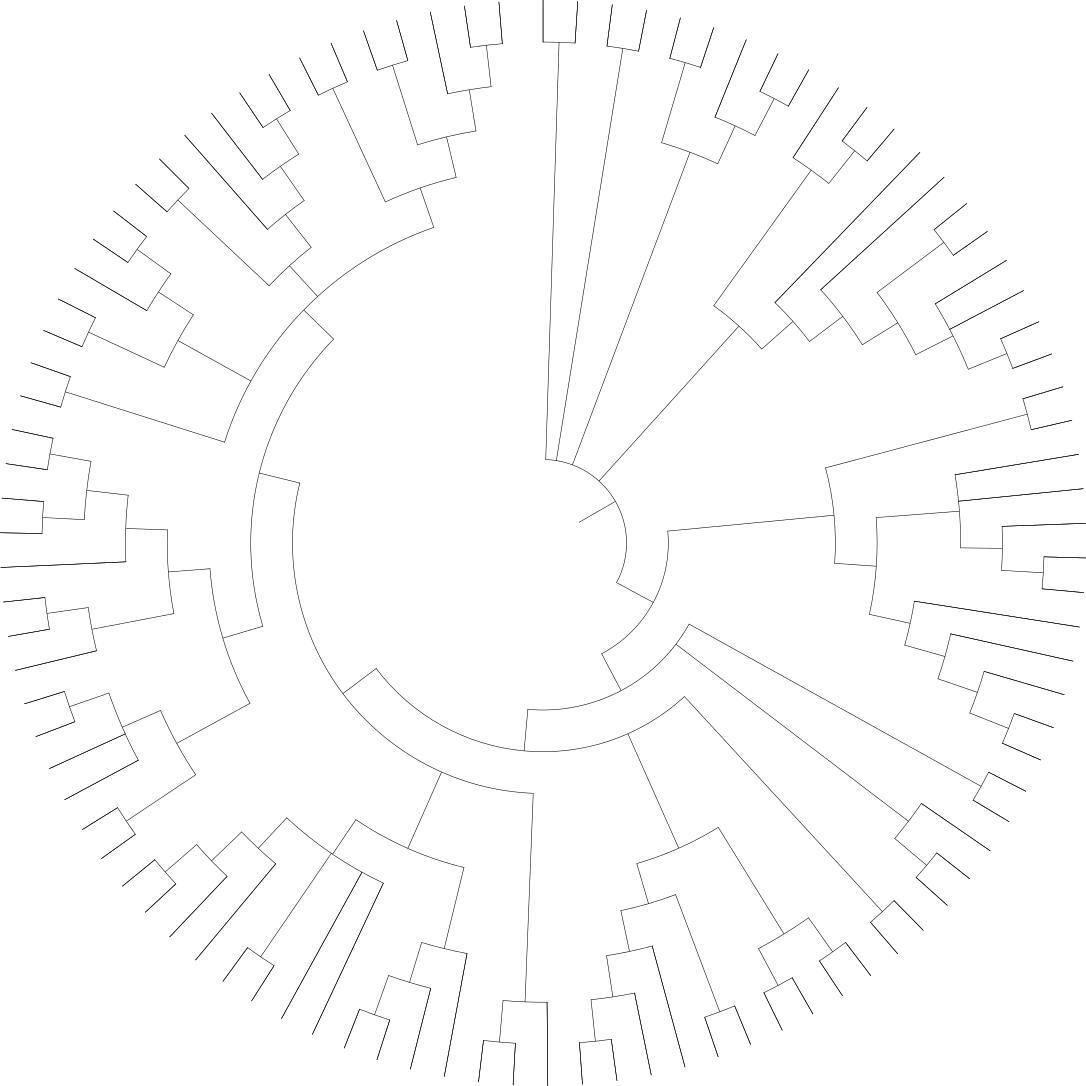

In [22]:
Image("example_nj_tree.png", width=500, height=500)

### ILPSolver

The `ILPSolver` is an implementaion of Steiner-Tree approach described in [Jones et al, 2020](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02000-8). The constructor takes in several options controlling the size and complexity of the potential graph to infer as well as stopping criteria for the integer-linear program (ILP) optimization routine.

There are several parameters of interest which can all be explored on our [documentation website](https://cassiopeia-lineage.readthedocs.io/en/testdeployment/api/reference/cassiopeia.solver.ILPSolver.html#cassiopeia.solver.ILPSolver). Because this process can take a long time, we'll restrict the potential graph layer size to 500 nodes and the convergence time to 500s. A more realistic solver might use our defaults - namely, a maximum potential graph layer size of 10,000 and a convergence time of 12,600s (3.5hr).

The `ILPSolver` logs the progress of the potential graph inference and optimization in a user-defined logfile (by default, `stdout.log`). This logfile will also be output here.

<div class="alert alert-block alert-warning" style="color:black;">
    <b>Heads up:</b> Make sure to have followed the instructions to install <a href url="https://www.gurobi.com/documentation/9.1/quickstart_mac/software_installation_guid.html">Gurobi</a> before proceeding with this solver.
</div>

In [18]:
ilp_solver = cas.solver.ILPSolver(convergence_time_limit=500, maximum_potential_graph_layer_size=500, weighted=True, seed=1234)
ilp_solver.solve(cas_tree)

#### Reading the logfile

The logfile from the `ILPSolver` contains several pieces of information helpful for assessing the effectiveness of the inference.

The first lines of the log convey the parameters used for the solver.

The next step of lines (preceded by "Process: ...") indicate the complexity of the potential graph inference. Each line indicates how large the potential graph is after adding ancestors up to an LCA distance of $x$. This process will terminate if a maximum layer size or maximum LCA distance is exceeded, whichever is first.

Finally, the log stores the output from the Gurobi optimization routine. This part of the logfile consists of several columns, but the most important two for most use cases are "Gap" and "Time", which store the convergence gap and amount of elapsed time. The ILP will terminate once the gap falls below the specified `mip_gap` or exceeds the specified `convergence_time_limit` or `convergence_iteration_limit` parameters.

The last few lines of the log after the ILP has finished will indicate whether or not an optimal model was found. To note, it is quite rare for an optimal model to be found so any tree inferred with an `ILPSolver` should be treated as a near-optimal model.

In [19]:
!head -50 stdout.log

[2021-07-28 15:30:05,538]    INFO [ILPSolver] Solving tree with the following parameters.
[2021-07-28 15:30:05,540]    INFO [ILPSolver] Convergence time limit: 500
[2021-07-28 15:30:05,562]    INFO [ILPSolver] Convergence iteration limit: 0
[2021-07-28 15:30:05,562]    INFO [ILPSolver] Max potential graph layer size: 500
[2021-07-28 15:30:05,596]    INFO [ILPSolver] Max potential graph lca distance: None
[2021-07-28 15:30:05,617]    INFO [ILPSolver] MIP gap: 0.01
[2021-07-28 15:30:06,350]    INFO [ILPSolver] (Process: 87e61250efe7f98c8eeaeeac4e2cd38b) Estimating a potential graph with a maximum layer size of 500 and a maximum LCA distance of 75.
[2021-07-28 15:30:16,255]    INFO [ILPSolver] (Process: 87e61250efe7f98c8eeaeeac4e2cd38b) LCA distance 0 completed with a neighborhood size of 145.
[2021-07-28 15:30:31,152]    INFO [ILPSolver] (Process: 87e61250efe7f98c8eeaeeac4e2cd38b) LCA distance 1 completed with a neighborhood size of 145.
[2021-07-28 15:32:29,951]    INFO [ILPSolver] (Pro

In [21]:
rndict = {}
_iter = 0
for n in cas_tree.nodes:
    if ',' in n:
        rndict[n] = f'node{_iter}'
        _iter += 1
        
cas_tree.relabel_nodes(rndict)

In [22]:
# plot tree
cas.pl.upload_and_export_itol(cas_tree, itol_config="~/.itolconfig_hidden",
                              tree_name = "example_ilp_tree", export_filepath="example_ilp_tree.png")

iTOL output: SUCCESS: 12832112124417641627512395

Tree Web Page URL: http://itol.embl.de/external.cgi?tree=12832112124417641627512395&restore_saved=1
Warnings: []


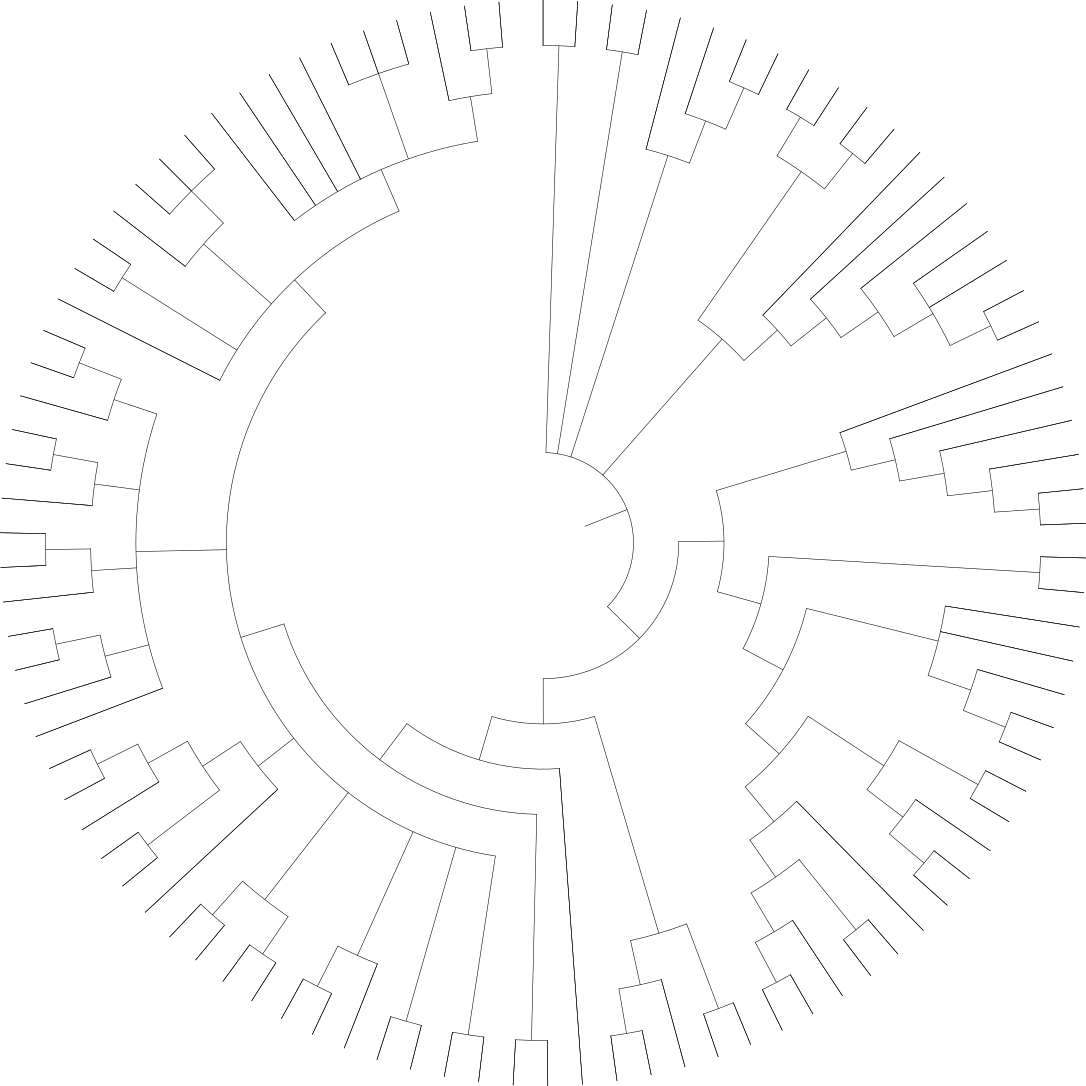

In [23]:
Image("example_ilp_tree.png", width=500, height=500)

### HybridSolver

The `HybridSolver` class implemented in Cassiopeia is a flexible class that takes in two solvers: first, a top-down greedy solver (this _must_ be an class that inherits from the `GreedySolver` class) and a bottom-solver of any type. Here, we'll show how this class can be used by using the Cassiopeia-Hybrid solver described in [Jones et al, 2020](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02000-8) that combines the `VanillaGreedySolver` with the `ILPSolver`.

While the HybridSolver will use the parameters set in its respective top and bottom solvers, a user will need to specify cutoff criteria for transitioning between the top and bottom solver, as well as the number of threads to use. Here, we'll use an cell cutoff of 20 for transitioning between Greedy and ILP, and use the `ILPSolver` and `VanillaGreedySolvers` that were instantiated above.

In [ ]:
hybrid_solver = cas.solver.HybridSolver(top_solver=vanilla_greedy, bottom_solver=ilp_solver, cell_cutoff=40, threads=10)
hybrid_solver.solve(cas_tree, logfile='example_hybrid.log')

### Interpreting the log files

The `HybridSolver` will create a logfile for each sub-problem, and will output any output speicfic to that problem to this specific log file. These logfiles will all share the same stem (e.g., 'example_hybrid'), but have indicate which the root of the sub-problem (these are nodes in the in-progress tree). 

In [20]:
!ls | grep 'example_hybrid'

example_hybrid_0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0-0.log
example_hybrid_0-0-0-4-0-0-0-0-0-6-0-2-0-0-0-0-0-0-7-5-0-0-0-3-4-0-0-0-0-3-0--1--1--1-0-0-0-0-0-0-0-0-0-0-3-0-0-0-0-0-0-0-0-2-3-0-0-3-0-0-0-3-0-0-0-4-0-0-0-2.log
example_hybrid_0-0-0-4-0-0-0-0-0-6-0-2-0-0-0-0-0-0-7-5-0-0-0-3-4-0-0-0-0-3-0--1--1--1-0-0-0-0-0-0-0-0-0-0-3-0-0-0-0-0-3-0-0-2-3-0-0-3-0-0-0-3-0-0-0-4-0-0-0-0.log
example_hybrid_0-0-0-4-0-0-12-0-0-6-0-2-0-0-0-0-6-5-7-5-0-0-0-3-4-0-0-0-2-3-0--1--1--1-0-0-0-0-0-0-0-0-0-3-4-0-0-0-0-0-0-0-0-2-3-0-0-3-1-0-0-3-0-1-0-4-0-2-0-2.log
example_hybrid_0-5-0-4-7-0-0-0-0-6-0-2-0-0-0-0-0-0-7-5-0-0-0-3-4-0-0-0-0-3-0--1--1--1-0-0-0-0-0-0-0-0-0-3-3-0--1--1--1--1--1--1--1-2-4-0--1--1-0-0-0-3-3-5-0-4-0-0-0-2.log
example_hybrid_0-9-6-4-0-0-0-0-0-6-0-2-6-0-0-0-0-0-7-5-0-0-0-3-4-0-0-0-0-3-0--1--1--1-0-0-0-0-0-0-0-0-0-0-3-0-0-0-0-0-0-0-0-2-3-0-0-3-0-0-0-3-0-0-0-4-0-0-0-2.log
example_hybrid_-1--1-

In [22]:
rndict = {}
_iter = 0
for n in cas_tree.nodes:
    if ',' in n:
        rndict[n] = f'node{_iter}'
        _iter += 1
        
cas_tree.relabel_nodes(rndict)

In [23]:
# plot tree
cas.pl.upload_and_export_itol(cas_tree, itol_config="~/.itolconfig_hidden",
                              tree_name = "example_hybrid_tree", export_filepath="example_hybrid_tree.png")

iTOL output: SUCCESS: 12832112124430351627521566

Tree Web Page URL: http://itol.embl.de/external.cgi?tree=12832112124430351627521566&restore_saved=1
Warnings: []


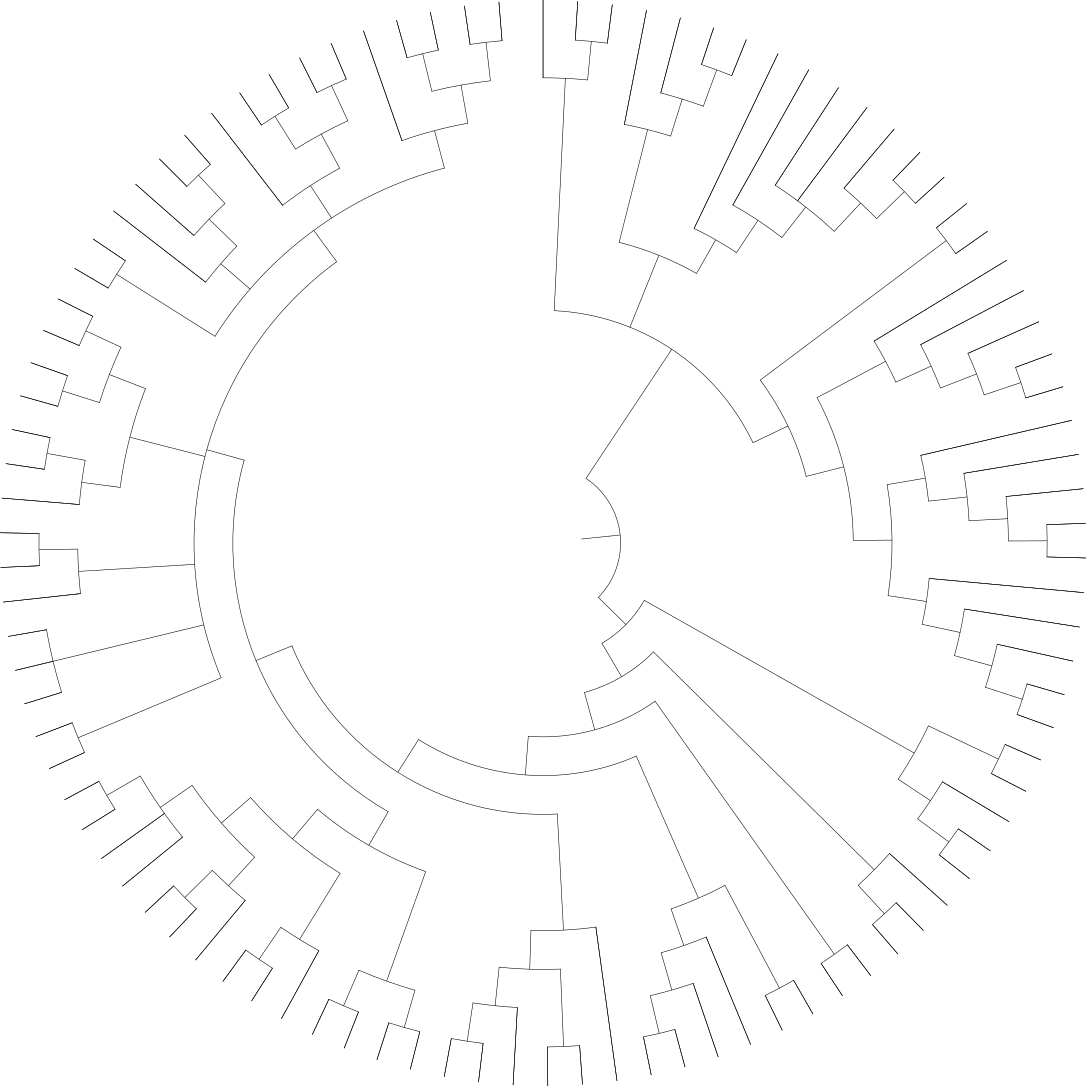

In [24]:
Image("example_hybrid_tree.png", width=500, height=500)